In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import os, glob
from neo.io import BlackrockIO

In [2]:
patient = 12

load ns6

In [3]:
if patient == 12:
    io = BlackrockIO(filename='../../results/202512/raw/datafile_202512b002')
else:
    io = BlackrockIO(filename=f'../../results/2025{patient}/raw/Hub1-20251004-160040-002')
block = io.read_block(lazy=False)
seg = block.segments[0]
ns6_sig = [sig for sig in seg.analogsignals if sig.annotations.get('nsx') == 6][0]

In [4]:
print(" name:            ", ns6_sig.name)
print(" sampling_rate:   ", ns6_sig.sampling_rate)
print(" units:           ", ns6_sig.units)
print(" shape (t, ch):  ", ns6_sig.shape)
print(" time vector unit:", ns6_sig.times.units)
print(" annotations:     ", ns6_sig.annotations)
print(" array_annotations keys:", ns6_sig.array_annotations.keys())
print(" array_annotations:", ns6_sig.array_annotations)
print()


 name:             nsx6
 sampling_rate:    30000.0 Hz
 units:            1.0 uV
 shape (t, ch):   (48890791, 32)
 time vector unit: 1.0 s
 annotations:      {'stream_id': np.str_('6'), 'nsx': 6}
 array_annotations keys: dict_keys(['channel_names', 'channel_ids', 'physical_connector', 'connector_pin', 'hi_freq_corner', 'lo_freq_corner', 'hi_freq_order', 'lo_freq_order', 'hi_freq_type', 'lo_freq_type'])
 array_annotations: {'channel_names': array(['chan97', 'chan98', 'chan99', 'chan100', 'chan101', 'chan102',
       'chan103', 'chan104', 'chan105', 'chan106', 'chan107', 'chan108',
       'chan109', 'chan110', 'chan111', 'chan112', 'chan113', 'chan114',
       'chan115', 'chan116', 'chan117', 'chan118', 'chan119', 'chan120',
       'chan121', 'chan122', 'chan123', 'chan124', 'chan125', 'chan126',
       'chan127', 'chan128'], dtype='<U7'), 'channel_ids': array(['97', '98', '99', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '110', '111', '112', '113', '114',

Inspect channels

In [5]:
pt_df = pd.read_csv(f'../../results/2025{patient}/records/QC_pt{patient}.csv')

# create boolean drift col which contains 1 if the 'notes' col contains 'drift'
pt_df['drift_flag'] = pt_df['notes'].apply(
    lambda x: 1 if 'drift' in str(x).lower() else 0
)

drift_chanIDs = pt_df.loc[pt_df['drift_flag'] == 1, 'chanID'].astype(int).tolist()
drift_chanIDs = np.unique(drift_chanIDs)
print(f'chanIDs with possible artifacts: {drift_chanIDs}')

pt_df[pt_df['drift_flag'] == 1]

chanIDs with possible artifacts: [ 97 105 106 107 109 111 112 113]


,chanID,unitID,keep,notes,drift_flag
0,97,596,NaN,FR; drift,1
19,105,1892,1.0,drift,1
20,105,1938,1.0,drift,1
22,106,2448,1.0,drift,1
23,106,2455,1.0,drift,1
28,107,1776,1.0,drift,1
36,109,1763,1.0,drift,1
44,111,1953,0.5,drift,1
46,111,1972,0.5,drift,1
49,112,2226,0.5,drift,1


In [6]:
chanIDs = pt_df['chanID'].unique()
print(f'chanIDs: {chanIDs}') # all chans
print(f'all channels shape: {ns6_sig.shape}')

# create map of chanID to signal, and plot 1 example
chan_sigs = {}
for chanID in chanIDs:
    chan_sigs[chanID] = ns6_sig[:, np.where(chanIDs == chanID)[0][0]]

    if chanID == 210:
        plt.figure(figsize=(12,2))
        plt.plot(chan_sigs[210][:60000], label='210')
        plt.legend(loc='upper right')
        plt.show()

chanIDs: [ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128]
all channels shape: (48890791, 32)


Plot all channels

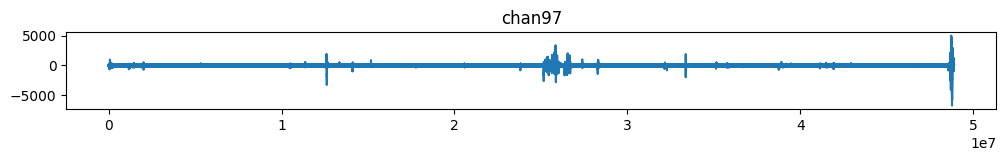

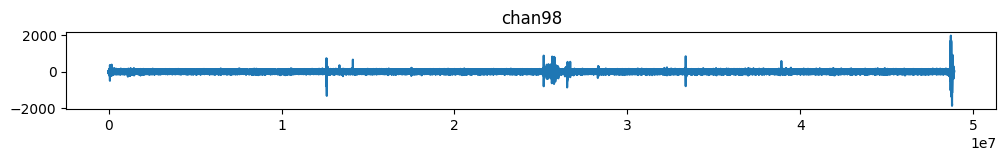

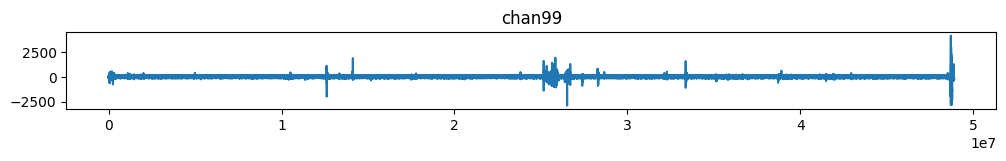

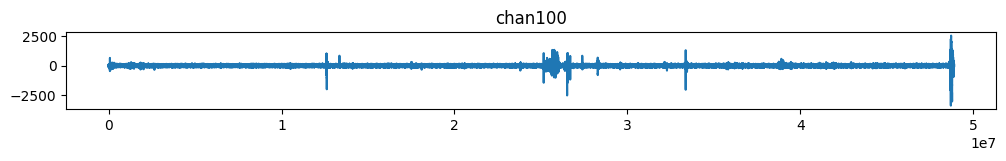

In [21]:
for chanID in chanIDs:
    plt.figure(figsize=(12,1))
    plt.plot(chan_sigs[chanID])
    plt.title(f'chan{chanID}')
    plt.show()

    if chanID - chanIDs[0] >= 3: break # after 5 chans

### load trig times to cut-off signals at end of final block

In [11]:
nev_file = glob.glob(f'../../results/2025{patient}/raw/*.nev')[0]
io = BlackrockIO(nev_file)
seg = io.read_block(lazy=False).segments[0]
dig_ev = [ev for ev in seg.events if "digital" in ev.name.lower()][0]

# map codes to labels
code_map = {
    10: "block started",
    20: "baseline started",
    30: "stim started",
    40: "delay started",
    50: "task started",
    51: "marker moved",
    52: "left pressed",
    53: "left released",
    54: "right pressed",
    55: "right released",
    56: "response submitted",
    60: "anticipation started",
    70: "feedback started",
    80: "block ended",
}

# build df
df_trigs = pd.DataFrame({
    "trigger_code": dig_ev.labels.astype(int),
    "time": dig_ev.times.magnitude
})
df_trigs["event"] = df_trigs["trigger_code"].map(code_map)

sess_start_time = df_trigs.loc[df_trigs["event"] == "block started", "time"].min()
print(f'start of session at {sess_start_time} s')
print(df_trigs.head(10))
sess_end_time = df_trigs.loc[df_trigs["event"] == "block ended", "time"].max()
print(f'end of session at {sess_end_time} s')
print(df_trigs.tail(10))    

start of session at 36.37996666666667 s
   trigger_code       time             event
0            20   0.475033  baseline started
1            30   1.408933      stim started
2            40   2.392100     delay started
3            10  36.379967     block started
4            20  70.978933  baseline started
5            30  71.864133      stim started
6            40  72.858367     delay started
7            50  74.342867      task started
8            51  75.375000      marker moved
9            52  75.375133      left pressed
end of session at 1613.2374333333332 s
      trigger_code         time                 event
2447            30  1608.433967          stim started
2448            40  1609.431467         delay started
2449            50  1610.816733          task started
2450            51  1611.714800          marker moved
2451            52  1611.714933          left pressed
2452            53  1611.848133         left released
2453            56  1611.981533    response subm

### plot signal after restricting to session duration

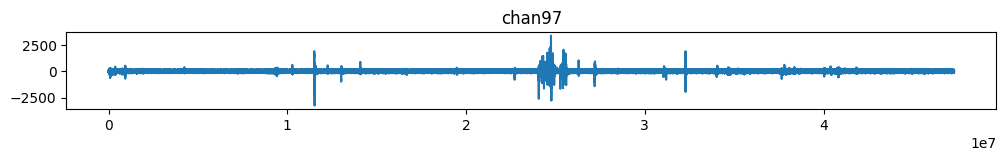

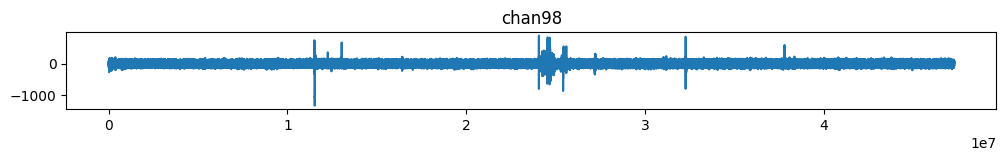

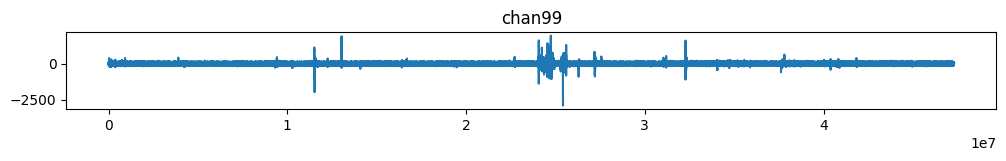

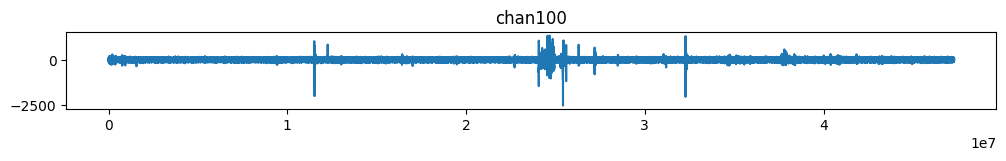

In [22]:
for chanID in chanIDs:

    raw_sig = chan_sigs[chanID]
    trimmed_sig = raw_sig[int(sess_start_time * raw_sig.sampling_rate) : int(sess_end_time * raw_sig.sampling_rate)]

    # update with trimmed sig
    chan_sigs[chanID] = trimmed_sig

for chanID in chanIDs:

    plt.figure(figsize=(12,1))
    plt.plot(chan_sigs[chanID])
    plt.title(f'chan{chanID}')
    plt.show()

    if chanID - chanIDs[0] >= 3: break # after 5 chans

### cleaning

In [20]:
# get channel signal
rand_drift_chanID = 106
chan_sig = chan_sigs[rand_drift_chanID]

# get signal properties
sig_samples = chan_sig.shape[0]
sig_freq = chan_sig.sampling_rate

# get time in seconds
sig_dur = sig_samples / sig_freq # roughly 1600s
plot_start, plot_end = 0, 300 # seconds

print(f'#samples: {sig_samples}')
print(f'sampling rate: {sig_freq}')
print(f'signal dur: {sig_dur}')

#samples: 48890791
sampling rate: 30000.0 Hz
signal dur: 1629.6930333333332 1/Hz


In [16]:
def get_clean_sig(raw_sig):

    sig = np.asarray(raw_sig, dtype=float).ravel() # flatten

    # # before z-scoring, exclude tail with clear outliers
    # trimmed_sig = sig[int(sess_start_time * raw_sig.sampling_rate) : int(sess_end_time * raw_sig.sampling_rate)]

    # identify outliers
    z = (sig - np.mean(sig)) / np.std(sig)
    outliers = np.abs(z) > 2      # mask of bad points
    print(f'#outliers: {np.sum(outliers)}')
    good_idx = np.where(~outliers)[0]
    bad_idx  = np.where(outliers)[0]

    # interpolate to replace outliers
    clean_sig = sig.copy()
    clean_sig[outliers] = np.interp(bad_idx, good_idx, sig[~outliers])
    return clean_sig

#samples: 48890791
sampling rate: 30000.0 Hz
signal dur: 1629.6930333333332 1/Hz
#outliers: 1079396


ValueError: x and y must have same first dimension, but have shapes (48890791,) and (47305724, 1)

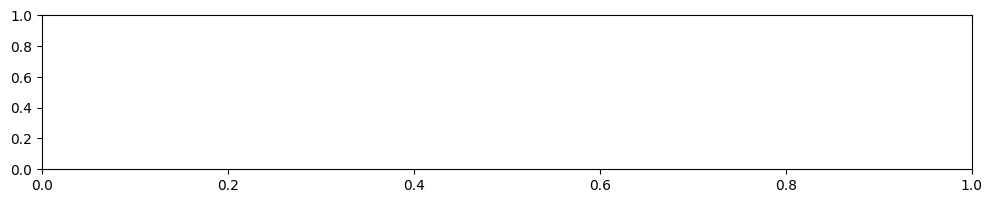

In [ ]:
# get channel signal
rand_drift_chanID = 106
chan_sig = chan_sigs[rand_drift_chanID]

# get signal properties
sig_samples = chan_sig.shape[0]
sig_freq = chan_sig.sampling_rate

# get time in seconds
sig_dur = sig_samples / sig_freq # roughly 1600s
plot_start, plot_end = 0, 300 # seconds

print(f'#samples: {sig_samples}')
print(f'sampling rate: {sig_freq}')
print(f'signal dur: {sig_dur}')

for chanID in chanIDs:

    if not chanID == rand_drift_chanID: continue

    raw_sig = chan_sigs[chanID]
    # trim to session dur
    trimmed_sig = raw_sig[int(sess_start_time * raw_sig.sampling_rate) :
                          int(sess_end_time * raw_sig.sampling_rate)]
    # remove outliers
    clean_sig = get_clean_sig(trimmed_sig)

    # determine time window to plot
    # 0, 500; 700, 1100; 0, sig_dur; 1500, sig_dur
    start_time, end_time = 0, sig_dur # seconds
    start_sampl, end_sampl = int(start_time*sig_freq), int(end_time*sig_freq)
    samples_in_secs = np.arange(start_sampl, end_sampl) / sig_freq
    
    plt.figure(figsize=(12,2))
    plt.plot(samples_in_secs, trimmed_sig[start_sampl:end_sampl], label='raw', alpha=0.7)
    # plt.plot(samples_in_secs, clean_sig[start_sampl:end_sampl], label='cleaned', alpha=0.7)
    
    plt.xlim(start_time, end_time)
    plt.title(f'chan{chanID} signal: raw vs cleaned')
    plt.xlabel('time (s)')
    plt.legend(loc='upper right')
    plt.show()


create new ns6  
create folder copy, then re-sort only select chans  
eventually, dont hard code chans in matlab

In [ ]:
# 1. Create a copy of the signal with cleaned channels
ns6_cleaned = ns6_sig.copy()

# 2. Replace drift channels with cleaned versions
chan_ids = np.array(ns6_sig.array_annotations["channel_ids"])
for chanID in drift_chanIDs:
    idx = np.where(chan_ids == str(chanID))[0][0]
    clean_sig = get_clean_sig(ns6_sig[:, idx])
    ns6_cleaned[:, idx] = clean_sig.reshape(-1, 1)

# 3. Replace the analogsignal in the segment
seg_cleaned = seg.duplicate_with_new_data([ns6_cleaned], deep_copy=True)
block_cleaned = block.duplicate_with_new_data([seg_cleaned], deep_copy=True)

# 4. Write to new .ns6 file
if patient == 12:
    out_path = '../../results/202512/raw/datafile_202512b002_cleaned'
else:
    out_path = f'../../results/2025{patient}/raw/Hub1-20251004-160040-002_cleaned'

# Note: BlackrockIO write support may be limited - verify with Neo version
# Alternative: save as HDF5 or use brpylib to write .ns6
io_out = BlackrockIO(filename=out_path)
io_out.write_block(block_cleaned)
print(f"Written to {out_path}.ns6")